![Image in a markdown cell](https://cursos.utnba.centrodeelearning.com/pluginfile.php/1/theme_space/customlogo/1738330016/Logo%20UTN%20Horizontal.png)

# **Diplomado de Ciencia de Datos y Análisis Avanzado**
# **Trabajo Final**
# **Credit Scoring**

## **Curso:** Diplomado en Ciencia de Datos

# **Nombres de los Miembros del Equipo:**
### *   Arenas, Diego
### *   Diaz, Augusto
### *   Galermes, Joaquin
### *   Palazón, Agustina
### *   Telis, Monica
### *   Vidable, Ignacio


## Setup del proyecto

### Entorno y librerías necesarias

In [1]:
# NOTA: Utilizamos GPU T4 como hardware accelerator para el presente trabajo.

# Instalamos las librerías requeridas (funciona en Colab)
!pip install -q scikit-learn imbalanced-learn xgboost lightgbm shap matplotlib seaborn gdown

# Importamos librerías base
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import sklearn, imblearn
import xgboost as xgb
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')
import logging

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, precision_score, precision_recall_curve, PrecisionRecallDisplay,
                             average_precision_score, classification_report,
                             confusion_matrix, roc_curve, RocCurveDisplay, recall_score, f1_score, ConfusionMatrixDisplay)
from imblearn.over_sampling import SMOTE


# Control de logs de librerías
logging.getLogger("lightgbm").setLevel(logging.ERROR)
logging.getLogger("xgboost").setLevel(logging.WARNING)

### Reproducibilidad (Seeds y versiones)

In [2]:
# Definimos la semilla para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

print("Semilla de reproducibilidad definida en:", SEED)

print("Python:", sys.version)
print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Imbalanced-learn:", imblearn.__version__)
print("XGBoost:", xgb.__version__)
print("LightGBM:", lgb.__version__)
print("SHAP:", shap.__version__)

Semilla de reproducibilidad definida en: 42
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Numpy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1
Imbalanced-learn: 0.14.0
XGBoost: 3.0.5
LightGBM: 4.6.0
SHAP: 0.48.0


Parámetros de costos de negocio y resolución de búsqueda de umbral

In [33]:
costo_FN = 100.0   # costo de dejar pasar un fraude (Falso Negativo)
costo_FP = 1.0     # costo de revisar una transacción legítima (Falso Positivo)
threshold_grid = 200  # barrido de umbrales

### Acceso a los datos y rutas

In [3]:
# Ruta del dataset, utilizamos gdown por el peso y tamaño del archivo
file_id = "19gosHFxaENn4cGEm8-h_mNMOCZN8mJ7Y"
url = f"https://drive.google.com/uc?id={file_id}"

output = "creditcard.csv"

gdown.download(url, output, quiet=False)

df = pd.read_csv(output)
print("Dataset cargado correctamente. Dimensiones:", df.shape)

Downloading...
From (original): https://drive.google.com/uc?id=19gosHFxaENn4cGEm8-h_mNMOCZN8mJ7Y
From (redirected): https://drive.google.com/uc?id=19gosHFxaENn4cGEm8-h_mNMOCZN8mJ7Y&confirm=t&uuid=611fc3d0-9bc2-439b-9afb-006b013cbdc6
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:01<00:00, 98.6MB/s]


Dataset cargado correctamente. Dimensiones: (284807, 31)


## Business Understanding

### Resumen ejecutivo

En este proyecto nos proponemos abordar el problema de la **detección de fraude en transacciones con tarjeta de crédito**.  
El fraude representa una de las principales fuentes de pérdidas para bancos y empresas del sector FinTech, no solo en términos económicos directos, sino también en la confianza de los clientes y la reputación de las instituciones.  

Nuestro objetivo es **desarrollar un modelo de Machine Learning** que sea capaz de identificar transacciones potencialmente fraudulentas de manera temprana y precisa.  
Para esto, utilizamos un conjunto de datos real y anonimizado que contiene operaciones con tarjeta de crédito, donde cada registro está etiquetado como transacción legítima o fraudulenta.  

El proyecto nos permitirá:  
- Aplicar la metodología **CRISP-DM**, siguiendo las etapas de comprensión del negocio, análisis de datos, preparación, modelado y evaluación.  
- Implementar distintos algoritmos de clasificación y comparar su desempeño mediante métricas como **AUC-ROC, Recall, Precision y F1-Score**, que son críticas en escenarios con clases desbalanceadas.  
- Evaluar los beneficios de negocio que una solución de este tipo podría aportar, incluyendo **reducción de pérdidas económicas, mayor seguridad en las transacciones y aumento de la confianza de los clientes**.  

Con este trabajo buscamos demostrar cómo la ciencia de datos puede generar valor en un caso de uso real y estratégico para el sector financiero, alineado con la creciente necesidad de **automatización y prevención de fraude en el ecosistema digital**.  

### Definición del problema y relevancia

El fraude con tarjetas de crédito es un desafío constante para las instituciones financieras y empresas del ecosistema FinTech.  
Cada año se producen millones de transacciones fraudulentas a nivel mundial, generando pérdidas económicas significativas, además de afectar la **confianza de los clientes** y la **reputación de las entidades financieras**.  

El problema que nos proponemos resolver es el siguiente:  
**¿Podemos construir un modelo de Machine Learning que identifique de manera temprana y confiable las transacciones fraudulentas, minimizando al mismo tiempo el impacto en clientes legítimos?**  

Este problema es relevante porque:  
- Permite a las instituciones **reducir pérdidas económicas directas** al detectar intentos de fraude en tiempo real.  
- Contribuye a **mejorar la seguridad y experiencia del cliente**, evitando bloqueos innecesarios de transacciones legítimas.  
- Favorece la **eficiencia operativa**, al disminuir la necesidad de revisiones manuales de gran volumen de transacciones.  
- Se alinea con los objetivos estratégicos del sector financiero: **confianza, seguridad, escalabilidad y cumplimiento regulatorio**.  

**Objetivo medible:**  
Desarrollar un modelo que alcance un **AUC-ROC superior a 0.90** y un **Recall alto (≥80%) en la clase de fraude**, asegurando la detección de la mayoría de los casos fraudulentos sin generar una cantidad excesiva de falsos positivos.  

**Hipótesis de trabajo:**  
Si aplicamos técnicas de tratamiento de desbalanceo de clases y probamos distintos algoritmos de clasificación (Logistic Regression, Random Forest, XGBoost, LightGBM), entonces podremos construir un modelo capaz de predecir fraudes con un desempeño adecuado para ser utilizado en un entorno realista del sector financiero.  

## Data Understanding

### Datos y metodología (EDA, diccionario de variables, nulos, outliers, etc.)

En esta sección nos enfocamos en comprender la estructura y calidad de los datos antes de iniciar el modelado.  
Trabajamos con el dataset **“Credit Card Fraud Detection”**, que contiene **284.807 transacciones** con información anonimizada de clientes europeos.  

### Características principales del dataset (Diccionario)
- **Time**: Tiempo en segundos desde la primera transacción en el dataset.  
- **Amount**: Monto de la transacción en la moneda original (no especificada).  
- **Class**: Variable objetivo (0 = legítima, 1 = fraude).  
- **V1 – V28**: Variables anonimizadas obtenidas por reducción de dimensionalidad (PCA).  
  - No representan un atributo único, sino combinaciones de múltiples características originales (ej. información del cliente, comercio, terminal, historial).  
  - Aunque no podemos conocer su significado exacto por motivos de confidencialidad, es posible analizarlas estadísticamente y medir su relación con la variable objetivo.  
  - Estudios previos indican que ciertos componentes (como V14 y V17) tienden a aportar mayor poder predictivo.  

- Tamaño del dataset: 284.807 filas × 31 columnas.  
- Distribución de clases: altamente **desbalanceada**, con aproximadamente **0,17% de transacciones fraudulentas**.  


### Análisis descriptivo

In [4]:
# Vemos las primeras filas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Revisamos dimensiones y tipos de datos
print("Dimensiones del dataset:", df.shape)
print("\nInformación general:")
print(df.info())

Dimensiones del dataset: (284807, 31)

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  f

In [6]:
# Estadísticas descriptivas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [7]:
# Distribución de la variable objetivo
fraudes = df['Class'].sum()
total = len(df)
print(f"Transacciones totales: {total}")
print(f"Fraudes: {fraudes} ({fraudes/total:.4%})")
print(f"Legítimas: {total-fraudes} ({(total-fraudes)/total:.4%})")

Transacciones totales: 284807
Fraudes: 492 (0.1727%)
Legítimas: 284315 (99.8273%)


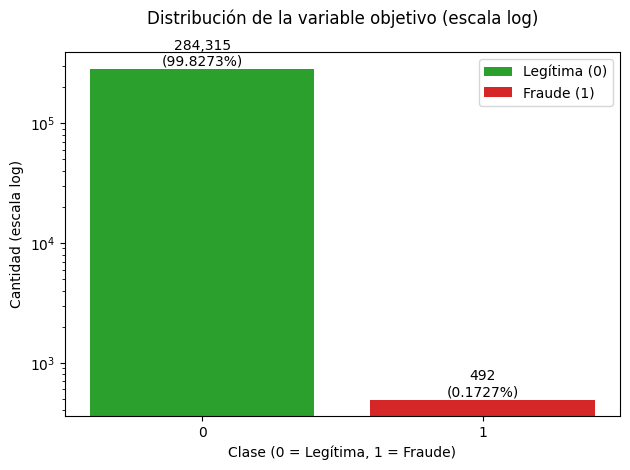

In [8]:
# Visualizamos la distribución de la variable objetivo
cuentas = df['Class'].value_counts().sort_index()
porc = (cuentas / cuentas.sum() * 100).round(4)
colores = ['#2ca02c', '#d62728']
fig, ax = plt.subplots()
barras = ax.bar(cuentas.index.astype(str), cuentas.values, color=colores)

ax.set_yscale('log')
ax.set_title("Distribución de la variable objetivo (escala log)", pad=20)
ax.set_xlabel("Clase (0 = Legítima, 1 = Fraude)")
ax.set_ylabel("Cantidad (escala log)")

# Etiquetas con conteo y porcentaje
for i, v in enumerate(cuentas.values):
    ax.text(i, v, f"{v:,}\n({porc.iloc[i]}%)", ha='center', va='bottom')

ax.legend(barras, ['Legítima (0)', 'Fraude (1)'])

plt.tight_layout()
plt.show()

In [9]:
# Revisamos valores faltantes
faltantes = df.isnull().sum()
print("Valores faltantes por variable:")
print(faltantes[faltantes > 0])

Valores faltantes por variable:
Series([], dtype: int64)


### Tratamiento de duplicados

In [10]:
# Revisamos valores duplicados
duplicados = df.duplicated().sum()
print(f"Cantidad de filas duplicadas: {duplicados}")
if duplicados > 0:
    print("El dataset contiene filas duplicadas que podrían requerir limpieza.")
else:
    print("No se encontraron duplicados en el dataset.")

Cantidad de filas duplicadas: 1081
El dataset contiene filas duplicadas que podrían requerir limpieza.


In [11]:
# Filtramos esos duplicados para analizarlos más en detalle
df_duplicados = df[df.duplicated(keep=False)]

df_duplicados.head(20)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
32,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
34,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
112,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
220,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0
221,145.0,-2.420413,1.947885,0.553646,0.983069,-0.281518,2.408958,-1.401613,-0.188299,0.675878,...,1.213826,-1.238620,0.006927,-1.724222,0.239603,-0.313703,-0.188281,0.119831,6.00,0


In [12]:
# Cantidad de duplicados por clase (fraude vs. legítima)
print("Duplicados por clase:")
print(df_duplicados['Class'].value_counts())

Duplicados por clase:
Class
0    1822
1      32
Name: count, dtype: int64


In [13]:
# Porcentaje de duplicados respecto al total
print("Porcentaje de duplicados:", (len(df_duplicados) / len(df)) * 100, "%")

Porcentaje de duplicados: 0.6509671461726713 %


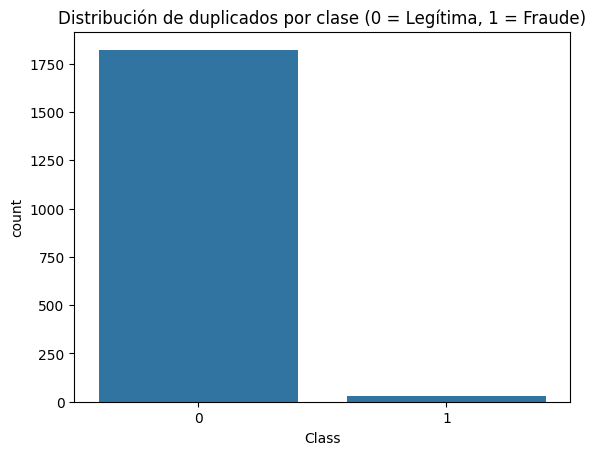

In [14]:
# Visualizamos si los duplicados corresponden más a fraudes o a transacciones legítimas
sns.countplot(x="Class", data=df_duplicados)
plt.title("Distribución de duplicados por clase (0 = Legítima, 1 = Fraude)")
plt.show()

### Tratamiento de outliers

**Nota:** En esta etapa buscamos identificar valores extremos que puedan afectar el modelado.  
Nos enfocamos en las variables **Amount** y **Time**, ya que son las únicas con interpretación directa, mientras que las variables **V1–V28** provienen de una transformación PCA y no pueden interpretarse de manera individual.  


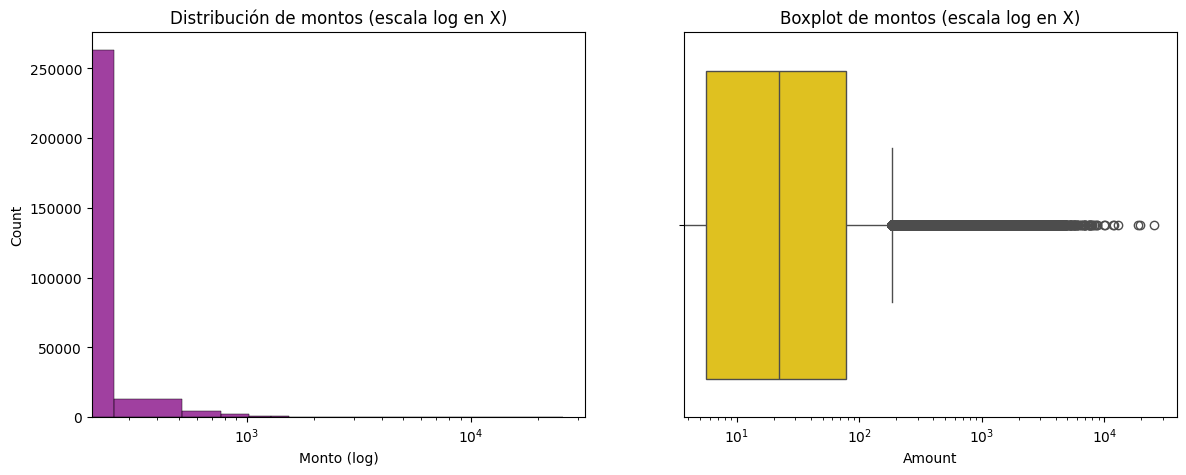

In [15]:
# Histograma y boxplot con escala logarítmica en el eje X
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['Amount'], bins=100, ax=ax[0], color="purple")
ax[0].set_xscale('log')
ax[0].set_title("Distribución de montos (escala log en X)")
ax[0].set_xlabel("Monto (log)")

sns.boxplot(x=df['Amount'], ax=ax[1], color="gold")
ax[1].set_xscale('log')
ax[1].set_title("Boxplot de montos (escala log en X)")

plt.show()

In [16]:
# Outliers usando IQR en Amount
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_amount = df[(df['Amount'] < limite_inferior) | (df['Amount'] > limite_superior)]
print(f"Cantidad de outliers en Amount: {len(outliers_amount)}")
print(f"Porcentaje de outliers: {len(outliers_amount)/len(df)*100:.2f}%")

Cantidad de outliers en Amount: 31904
Porcentaje de outliers: 11.20%


In [17]:
# Distribución de outliers por clase
print("Outliers por clase en Amount:")
print(outliers_amount['Class'].value_counts())

Outliers por clase en Amount:
Class
0    31813
1       91
Name: count, dtype: int64


**Conclusiones:**
- Distribución sesgada a la derecha. La gran mayoría de las transacciones son de montos bajos (cercanos a 0-200 unidades monetarias).
- Se identificaron 31.904 outliers (≈ 11,20% del dataset) según el criterio estadístico de IQR. De esos outliers, 31.813 son transacciones legítimas y solo 91 corresponden a fraudes. Esto significa que los fraudes no se concentran en montos extremadamente altos, sino que pueden ocurrir en cualquier rango.
- Los montos altos no parecen ser un indicador fuerte de fraude por sí solos. Eliminar outliers podría ser riesgoso, porque podríamos estar descartando información válida de transacciones legítimas.

#### Análisis de la variable Time
La variable `Time` representa los segundos transcurridos desde la primera transacción en el dataset.  
Nuestro objetivo es visualizar su distribución general y comparar si los fraudes ocurren con mayor frecuencia en ciertas franjas horarias.


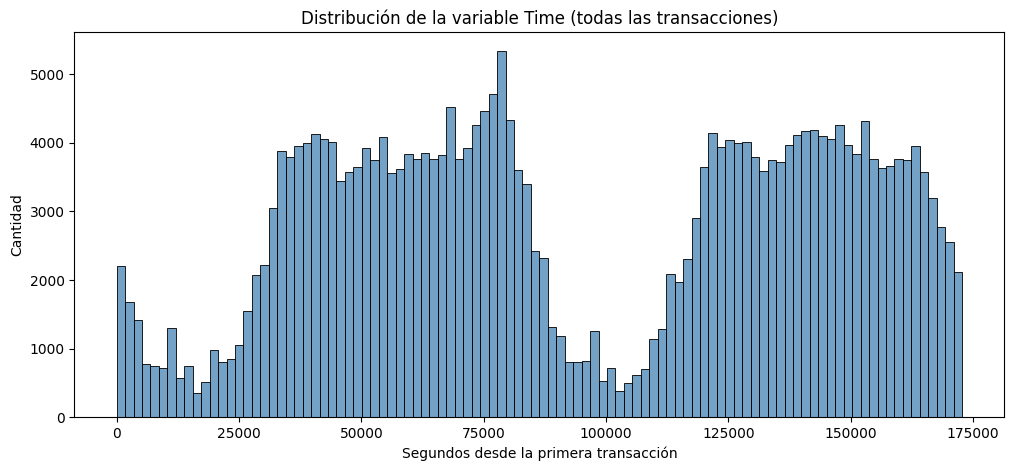

In [18]:
# Histograma de Time (todas las transacciones)
plt.figure(figsize=(12,5))
sns.histplot(df['Time'], bins=100, color="steelblue")
plt.title("Distribución de la variable Time (todas las transacciones)")
plt.xlabel("Segundos desde la primera transacción")
plt.ylabel("Cantidad")
plt.show()

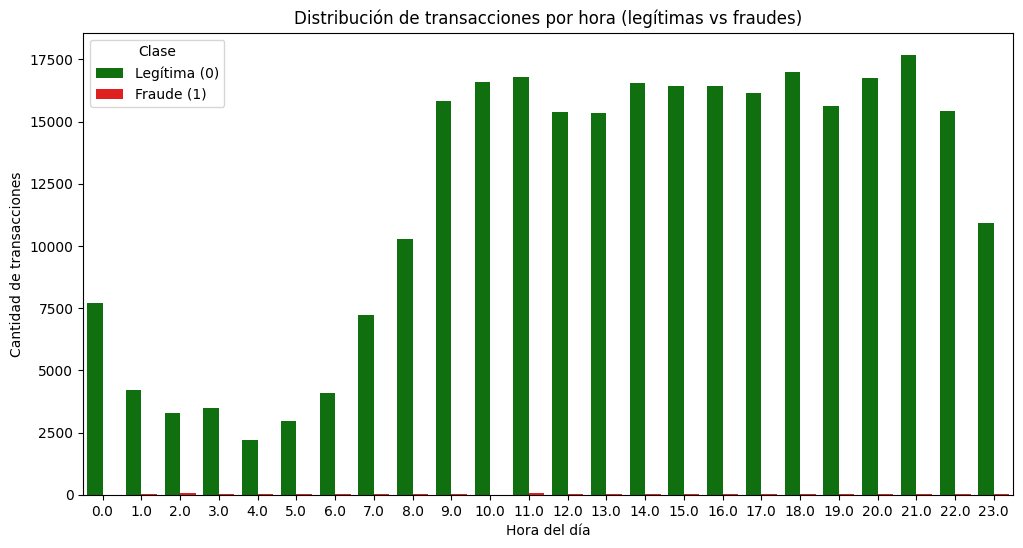

In [19]:
# Creamos una nueva variable: Hora aproximada de la transacción
df['Hour'] = (df['Time'] // 3600) % 24

# Distribución de fraudes vs. no fraudes por hora
plt.figure(figsize=(12,6))
sns.countplot(x='Hour', hue='Class', data=df, palette=['green','red'])
plt.title("Distribución de transacciones por hora (legítimas vs fraudes)")
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de transacciones")
plt.legend(title="Clase", labels=["Legítima (0)", "Fraude (1)"])
plt.show()

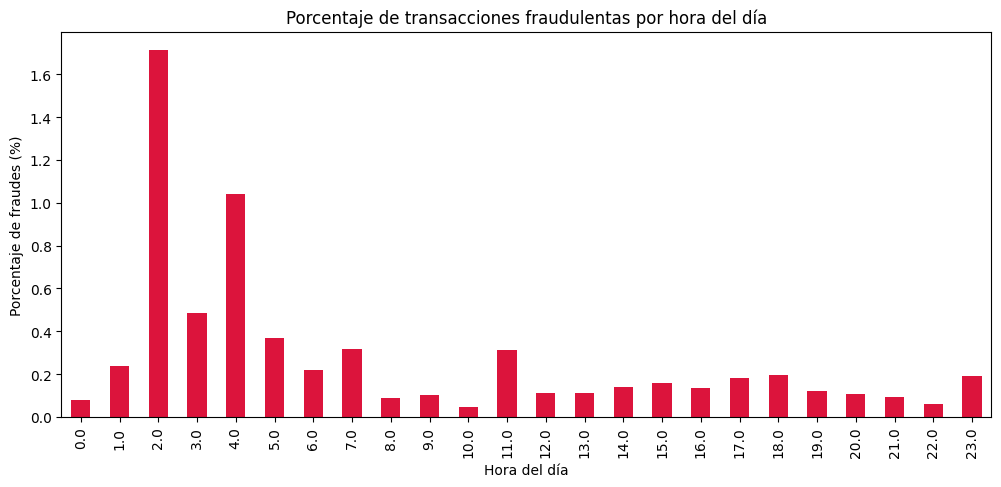

In [20]:
# Calculamos porcentaje de fraudes por hora
fraude_por_hora = df.groupby('Hour')['Class'].mean() * 100

plt.figure(figsize=(12,5))
fraude_por_hora.plot(kind='bar', color="crimson")
plt.title("Porcentaje de transacciones fraudulentas por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Porcentaje de fraudes (%)")
plt.show()

**Conclusión**  
La distribución de transacciones muestra un patrón claro de actividad durante el día, con mayor volumen entre las 8:00 y las 22:00 horas.  
Si bien los fraudes son poco frecuentes en general, el análisis por porcentaje revela que tienen una incidencia proporcionalmente mayor en las horas de la madrugada (aproximadamente entre la 1:00 y las 4:00 AM).  
Esto sugiere que los intentos de fraude tienden a concentrarse en horarios de baja actividad, cuando es más probable que pasen desapercibidos.


#### Análisis de las variables V1-V28
Para determinar la transformación más adecuada para las variables transformadas por PCA (V1 a V28), se generan histogramas que permitan analizar sus distribuciones.

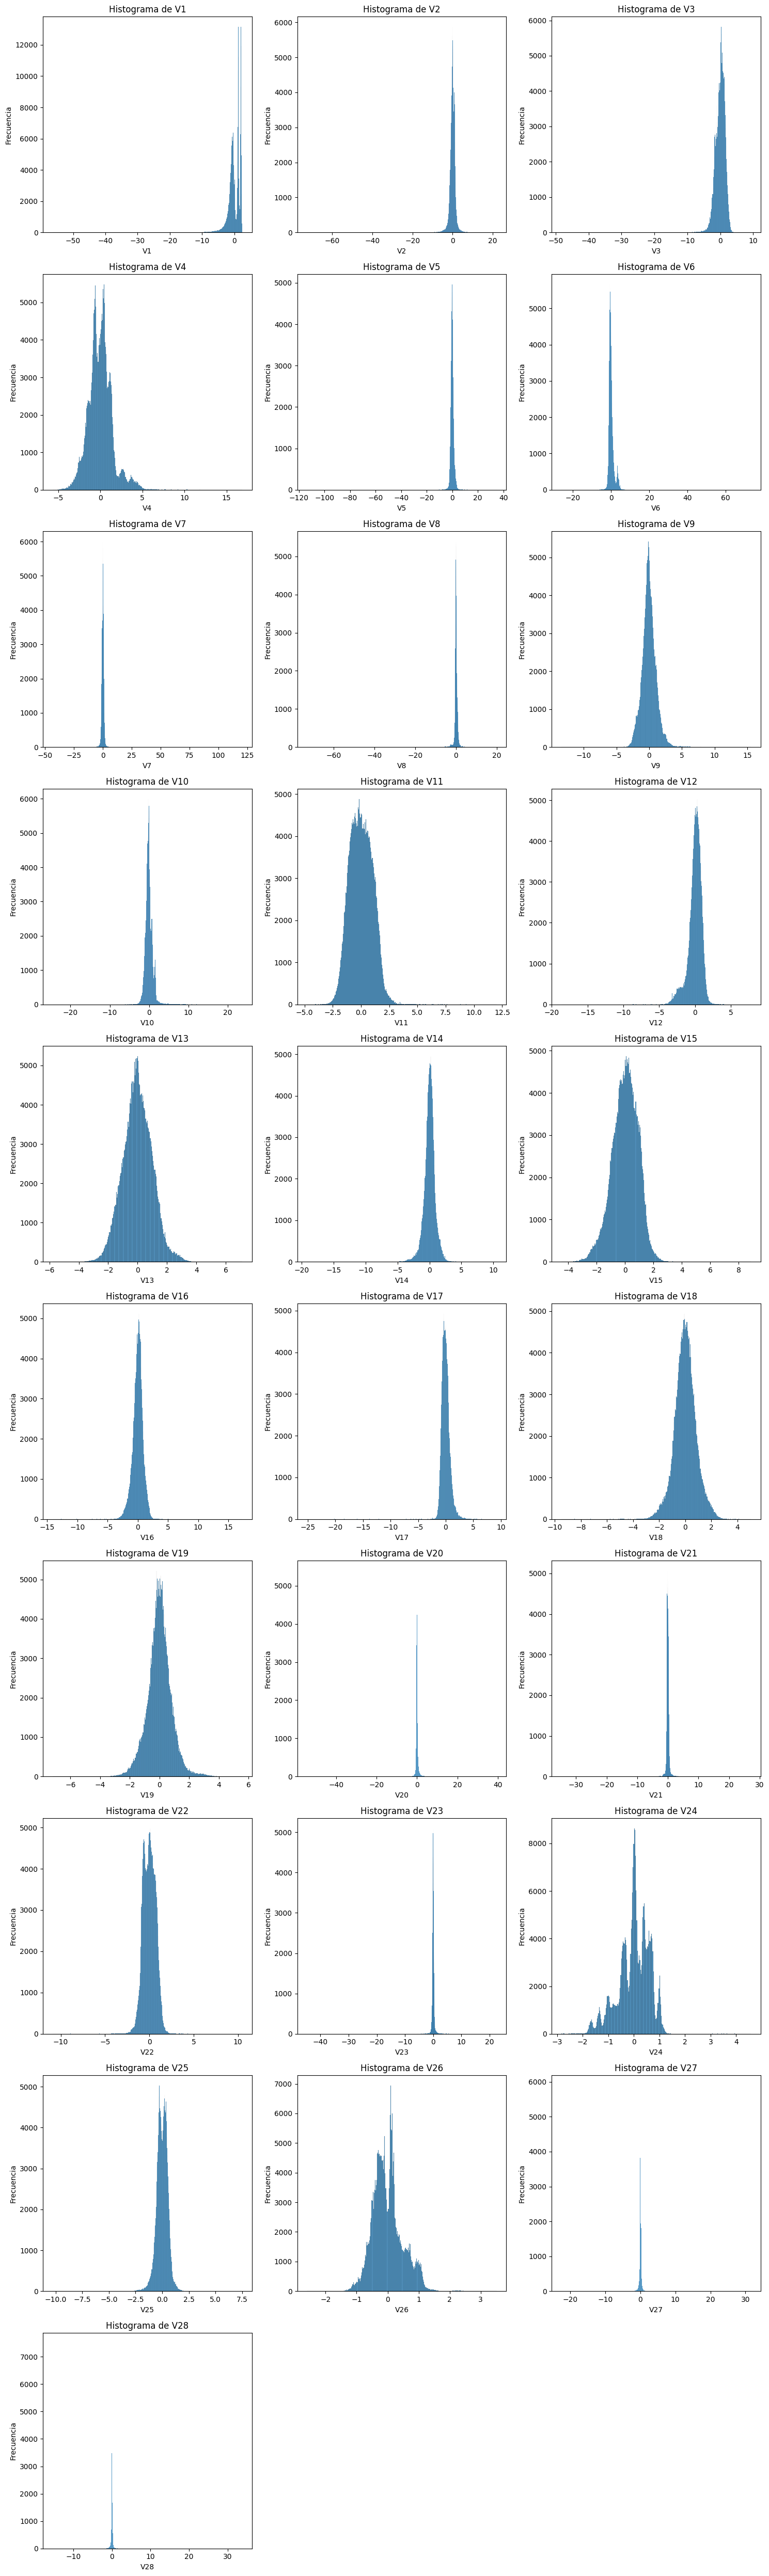

In [21]:
numeric_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

n_cols = len(numeric_cols)
n_rows = (n_cols + 2) // 3  # 3 histogramas por fila
fig, axes = plt.subplots(n_rows, min(n_cols, 3), figsize=(15, 5*n_rows))

# Aplanar el array de axes para facilitar la iteración
axes = axes.ravel() if n_cols > 1 else [axes]

# Crear un histograma para cada variable numérica
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Histograma de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Eliminar subplots vacíos si los hay
for i in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[i])

# Ajustar el layout
plt.tight_layout()
plt.show()

**Conclusión**  

Dado que las variables transformadas mediante PCA (V1 a V28) presentan distribuciones aproximadamente centradas y simétricas, según el análisis exploratorio, se opta por aplicar la estandarización Z-score Scaling.

## Data Preparation

In [22]:
# Copiamos el dataset original para trabajar
df_prep = df.copy()

# Transformación logarítmica de Amount (log1p para evitar log(0))
df_prep['Amount_log'] = np.log1p(df_prep['Amount'])

# Creamos la variable Hour (ya la teníamos antes pero la aseguramos aquí)
df_prep['Hour'] = (df_prep['Time'] // 3600) % 24

# Definimos las features y la variable objetivo
X = df_prep.drop(columns=['Class', 'Time', 'Amount'])  # quitamos la original de tiempo y amount crudo
y = df_prep['Class']

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (284807, 30)
Dimensiones de y: (284807,)


In [23]:
# Escalamos las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Escalado aplicado. Media de la primera columna:", round(X_scaled[:,0].mean(), 4))

Escalado aplicado. Media de la primera columna: -0.0


In [24]:
# Dividimos en conjuntos de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=SEED
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Distribución en entrenamiento:", np.bincount(y_train))
print("Distribución en prueba:", np.bincount(y_test))

Tamaño del conjunto de entrenamiento: (227845, 30)
Tamaño del conjunto de prueba: (56962, 30)
Distribución en entrenamiento: [227451    394]
Distribución en prueba: [56864    98]


## Modeling

## Modelado: Baseline y Comparación de Modelos

Entrenamos cinco modelos (Regresión Logística, Árbol de Decisión, Random Forest, XGBoost y LightGBM).  
Debido al fuerte desbalance de clases, aplicamos:
- `class_weight='balanced'` en modelos de scikit-learn.
- `scale_pos_weight` en XGBoost y LightGBM, calculado como `negativos/positivos` en entrenamiento.

Reportamos métricas en test: **AUC-ROC**, **AUC-PR (Average Precision)**, **Recall**, **Precision**, **F1** y la **Matriz de Confusión**.

**Nota:** Al ejecutar los cinco modelos en Google Colab utilizando una GPU T4, el tiempo total de entrenamiento ronda los **7 minutos** aproximadamente.  
Este tiempo es esperable dado el tamaño del dataset (~285.000 transacciones) y la complejidad de los algoritmos de ensamble como Random Forest, XGBoost y LightGBM.


In [25]:
# Nos aseguramos que X_train, X_test, y_train, y_test y SEED están definidos por la sección de Data Preparation
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_w = neg / pos if pos > 0 else 1.0

print("Relación de clases en train -> negativos/positivos:", round(scale_pos_w, 2))

Relación de clases en train -> negativos/positivos: 577.29


In [26]:
# Definimos los modelos con parámetros razonables y reproducibles
modelos = {
    "LogisticRegression": LogisticRegression(
        class_weight="balanced", max_iter=200, random_state=SEED, n_jobs=-1
    ),
    "DecisionTree": DecisionTreeClassifier(
        class_weight="balanced", random_state=SEED, max_depth=None, min_samples_leaf=1
    ),
    "RandomForest": RandomForestClassifier(
        class_weight="balanced", n_estimators=300, max_depth=None,
        n_jobs=-1, random_state=SEED
    ),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=scale_pos_w,
        eval_metric="auc", n_jobs=-1, random_state=SEED, verbosity=0
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=400, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8,
        num_leaves=31, max_depth=-1,
        scale_pos_weight=scale_pos_w,
        random_state=SEED, n_jobs=-1, verbosity=-1
    )
}

In [27]:
# Evaluamos los modelos
def evaluar_modelo(nombre, modelo, X_tr, y_tr, X_te, y_te):
    # Entrenamos
    modelo.fit(X_tr, y_tr)
    # Predicciones
    y_proba = modelo.predict_proba(X_te)[:, 1] if hasattr(modelo, "predict_proba") else modelo.decision_function(X_te)
    y_pred = (y_proba >= 0.5).astype(int)
    # Métricas
    auc = roc_auc_score(y_te, y_proba)
    ap = average_precision_score(y_te, y_proba)  # AUC-PR
    rec = recall_score(y_te, y_pred, zero_division=0)
    prec = precision_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    cm = confusion_matrix(y_te, y_pred)
    return {
        "modelo": nombre,
        "auc_roc": auc,
        "auc_pr": ap,
        "recall": rec,
        "precision": prec,
        "f1": f1,
        "tn": cm[0,0], "fp": cm[0,1], "fn": cm[1,0], "tp": cm[1,1]
    }

# Evaluamos todos y armamos tabla de resultados
resultados = []
for nombre, modelo in modelos.items():
    res = evaluar_modelo(nombre, modelo, X_train, y_train, X_test, y_test)
    resultados.append(res)

tabla_resultados = pd.DataFrame(resultados).sort_values(by=["auc_pr","auc_roc","f1"], ascending=False)
tabla_resultados.reset_index(drop=True, inplace=True)
tabla_resultados

,modelo,auc_roc,auc_pr,recall,precision,f1,tn,fp,fn,tp
0,XGBoost,0.983255,0.877673,0.846939,0.864583,0.855670,56851,13,15,83
1,RandomForest,0.967009,0.864970,0.765306,0.949367,0.847458,56860,4,23,75
2,LogisticRegression,0.970952,0.712809,0.908163,0.055452,0.104521,55348,1516,9,89
3,DecisionTree,0.856949,0.543970,0.714286,0.760870,0.736842,56842,22,28,70
4,LightGBM,0.768613,0.004236,0.846939,0.004691,0.009330,39253,17611,15,83


In [28]:
# Mostramos un resumen legible del mejor modelo según AUC-PR
mejor = tabla_resultados.iloc[0]
print("Mejor modelo según AUC-PR:")
for c in ["modelo","auc_pr","auc_roc","recall","precision","f1","tp","fp","fn","tn"]:
    print(f"{c}: {mejor[c]}")

Mejor modelo según AUC-PR:
modelo: XGBoost
auc_pr: 0.8776733975133347
auc_roc: 0.9832548910109908
recall: 0.8469387755102041
precision: 0.8645833333333334
f1: 0.8556701030927835
tp: 83
fp: 13
fn: 15
tn: 56851


**Conclusion:** Tras entrenar y evaluar los modelos en el set de prueba, los mejores resultados se obtuvieron con **XGBoost**, que alcanzó un **AUC-ROC ≈ 0.98** y un **AUC-PR ≈ 0.88**, con buen equilibrio entre **Recall (≈85%)** y **Precision (≈86%)**.  
Estos resultados lo posicionan como el modelo más adecuado para la tarea de detección de fraude en tarjetas de crédito.



---



**La siguiente matriz usa el umbral por defecto 0.5. En la sección Evaluation optimizamos el umbral por costo y reportamos las métricas finales en ese threshold.**

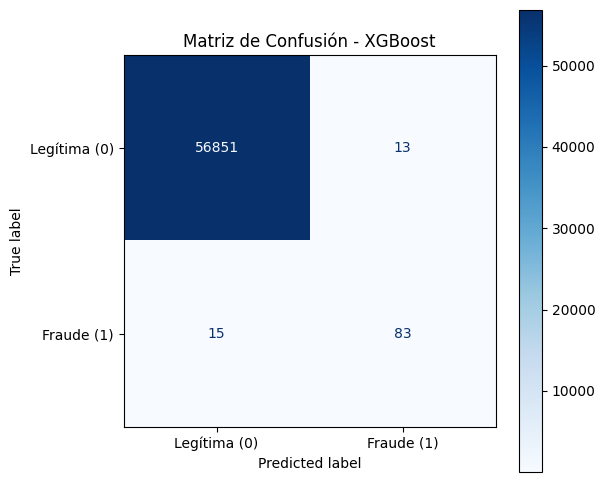

In [29]:
# Reentrenamos XGBoost en train y evaluamos en test (por si acaso no quedó en memoria)
mejor_modelo = modelos["XGBoost"]
mejor_modelo.fit(X_train, y_train)
y_pred = mejor_modelo.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legítima (0)", "Fraude (1)"])

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap="Blues", ax=ax, values_format="d")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

**Conclusión(XGBoost):**

- El modelo identificó correctamente **56.851 transacciones legítimas** y solo marcó **13 falsos positivos**.  
- Logró detectar **83 transacciones fraudulentas de un total de 98**, lo que representa una **cobertura (Recall) de aproximadamente 85%**.  
- Solo dejó escapar **15 fraudes (falsos negativos)**, lo que es bajo en relación al total.  

Esto confirma que el modelo ofrece un **muy buen balance entre detectar fraudes y no generar demasiadas alertas falsas**.  
Desde la perspectiva de negocio, esto es clave: se logra prevenir la mayoría de los fraudes sin bloquear injustamente un número elevado de transacciones legítimas.


## Evaluation

## Evaluación e Impacto en el Negocio

Los resultados obtenidos muestran que el modelo XGBoost es capaz de identificar con gran precisión los casos de fraude en tarjetas de crédito.  
El área bajo la curva ROC se acerca a 0.98 y la curva Precision–Recall también refleja un desempeño sólido, lo que confirma que el modelo mantiene un buen equilibrio entre capturar la mayoría de fraudes y minimizar las falsas alarmas.  

En la práctica, esto significa que la institución financiera podría prevenir una parte muy significativa de los fraudes realizando solo un numero reducido de revisiones manuales
  
Al reducir falsos positivos, se mejora la experiencia del cliente, evitando bloqueos injustificados de transacciones legítimas, y al mismo tiempo se disminuyen las pérdidas económicas asociadas al fraude.  

En síntesis, la evaluación confirma que este modelo no solo es técnicamente sólido, sino que también aporta valor directo al negocio al aumentar la seguridad y confianza en las operaciones con tarjeta de crédito.


Umbral óptimo por costo: 0.065  |  Costo esperado mínimo: 1144.00
TP=87  FP=44  FN=11  TN=56820
Precision=0.6641  Recall=0.8878  F1=0.7598


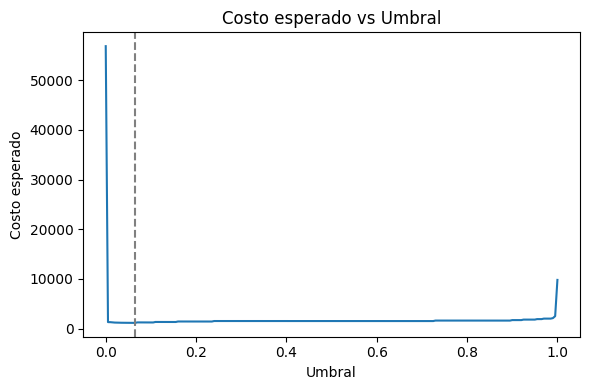

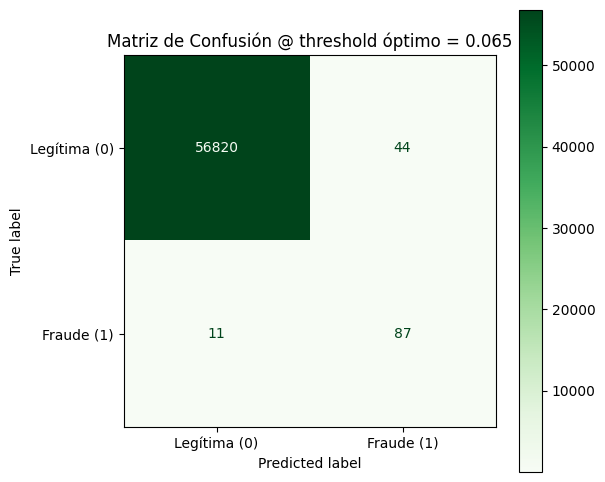

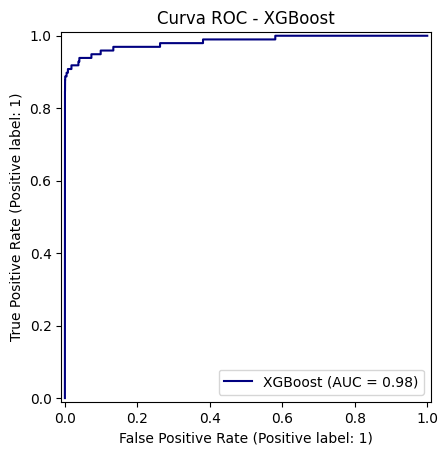

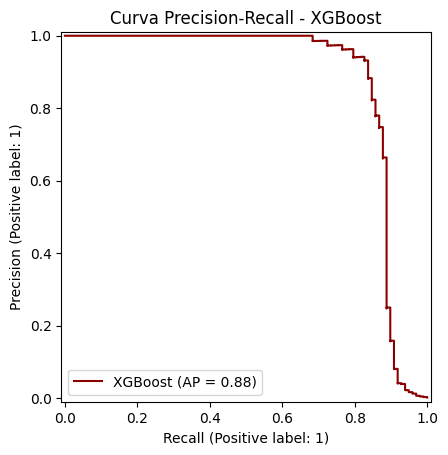

In [34]:
# Probabilidades del modelo
y_proba = mejor_modelo.predict_proba(X_test)[:,1]

def costo_esperado(y_true, y_proba, threshold, c_fn=100.0, c_fp=1.0):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn * c_fn + fp * c_fp

def barrido_umbral_por_costo(y_true, y_proba, c_fn=100.0, c_fp=1.0, grid=200):
    ths = np.linspace(0.0, 1.0, grid + 1)
    costos = np.array([costo_esperado(y_true, y_proba, th, c_fn, c_fp) for th in ths])
    i = costos.argmin()
    return ths[i], float(costos[i]), ths, costos

def reporte_a_umbral(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "threshold": float(threshold),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
    }

# === Selección de umbral óptimo por costo esperado ===
th_opt, costo_min, ths, costos = barrido_umbral_por_costo(
    y_test, y_proba, c_fn=costo_FN, c_fp=costo_FP, grid=threshold_grid
)
rep_opt = reporte_a_umbral(y_test, y_proba, th_opt)

print(f"Umbral óptimo por costo: {th_opt:.3f}  |  Costo esperado mínimo: {costo_min:.2f}")
print(f"TP={rep_opt['TP']}  FP={rep_opt['FP']}  FN={rep_opt['FN']}  TN={rep_opt['TN']}")
print(f"Precision={rep_opt['precision']:.4f}  Recall={rep_opt['recall']:.4f}  F1={rep_opt['f1']:.4f}")

# Curva de costo vs umbral (para justificar la elección)
plt.figure(figsize=(6,4))
plt.plot(ths, costos)
plt.axvline(th_opt, color='gray', linestyle='--')
plt.title("Costo esperado vs Umbral")
plt.xlabel("Umbral")
plt.ylabel("Costo esperado")
plt.tight_layout()
plt.show()

# Matriz de confusión a umbral óptimo (además de la de 0.5 que ya mostraste)
y_pred_opt = (y_proba >= th_opt).astype(int)
cm_opt = confusion_matrix(y_test, y_pred_opt)
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=["Legítima (0)", "Fraude (1)"])

fig, ax = plt.subplots(figsize=(6,6))
disp_opt.plot(cmap="Greens", ax=ax, values_format="d")
plt.title(f"Matriz de Confusión - threshold óptimo = {th_opt:.3f}")
plt.show()

# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba, name="XGBoost", color="navy")
plt.title("Curva ROC - XGBoost")
plt.show()

# Curva Precision-Recall
PrecisionRecallDisplay.from_predictions(y_test, y_proba, name="XGBoost", color="darkred")
plt.title("Curva Precision-Recall - XGBoost")
plt.show()

## Comparativa: baseline 0.5 vs umbral óptimo por costo

In [35]:
def resumen_en_umbral(y_true, y_proba, th, nombre):
    y_pred = (y_proba >= th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "Escenario": nombre,
        "Threshold": th,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "AUC_ROC": roc_auc_score(y_true, y_proba),
        "AUC_PR": average_precision_score(y_true, y_proba)
    }

base = resumen_en_umbral(y_test, y_proba, 0.5, "Baseline 0.5")
opt  = resumen_en_umbral(y_test, y_proba, th_opt, "Óptimo por costo")

comp_df = pd.DataFrame([base, opt])
comp_df = comp_df[["Escenario","Threshold","TP","FP","FN","TN","Precision","Recall","F1","AUC_ROC","AUC_PR"]]
display(comp_df.round(4))

,Escenario,Threshold,TP,FP,FN,TN,Precision,Recall,F1,AUC_ROC,AUC_PR
0,Baseline 0.5,0.500,83,13,15,56851,0.8646,0.8469,0.8557,0.9833,0.8777
1,Óptimo por costo,0.065,87,44,11,56820,0.6641,0.8878,0.7598,0.9833,0.8777


**Sensibilidad: cómo cambia el umbral si cambian los costos**

In [36]:
escenarios_costos = [
    ("FN=50, FP=1", 50, 1),
    ("FN=100, FP=1 (base)", 100, 1),
    ("FN=200, FP=1", 200, 1),
    ("FN=100, FP=2", 100, 2),
]

rows = []
for name, cfn, cfp in escenarios_costos:
    th, cmin, _, _ = barrido_umbral_por_costo(y_test, y_proba, c_fn=cfn, c_fp=cfp, grid=threshold_grid)
    rep = reporte_a_umbral(y_test, y_proba, th)
    rows.append({
        "EscenarioCostos": name,
        "Threshold_opt": th,
        "Costo_min": cmin,
        "Precision": rep["precision"],
        "Recall": rep["recall"],
        "F1": rep["f1"],
        "TP": rep["TP"], "FP": rep["FP"], "FN": rep["FN"], "TN": rep["TN"]
    })

sens_df = pd.DataFrame(rows).sort_values("Threshold_opt")
display(sens_df.round(4))

,EscenarioCostos,Threshold_opt,Costo_min,Precision,Recall,F1,TP,FP,FN,TN
0,"FN=50, FP=1",0.065,594.0,0.6641,0.8878,0.7598,87,44,11,56820
1,"FN=100, FP=1 (base)",0.065,1144.0,0.6641,0.8878,0.7598,87,44,11,56820
2,"FN=200, FP=1",0.065,2244.0,0.6641,0.8878,0.7598,87,44,11,56820
3,"FN=100, FP=2",0.065,1188.0,0.6641,0.8878,0.7598,87,44,11,56820


### Conclusiones finales

El trabajo realizado nos permitió aplicar la metodología CRISP-DM al problema de detección de fraude en tarjetas de crédito.  
Comenzamos con la comprensión del negocio y los datos, analizamos su distribución, detectamos la fuerte desproporción entre clases y preparamos el dataset con transformaciones adecuadas.  
Posteriormente entrenamos y comparamos distintos modelos de clasificación, desde opciones simples como la regresión logística hasta algoritmos más avanzados de ensamble.  

Los resultados muestran que el modelo **XGBoost** es el que ofrece el mejor equilibrio entre cobertura de fraudes y precisión, con métricas que lo convierten en una herramienta práctica y confiable.  
Detecta la mayoría de los fraudes, reduce al mínimo las falsas alarmas y se ajusta a las necesidades de un contexto real en el sector financiero, donde tanto la seguridad como la experiencia del cliente son críticas.  

Como recomendación, proponemos implementar este modelo como base de un sistema de detección de fraude en tiempo real.  
Además, sugerimos continuar con un proceso de mejora continua, que incluya la actualización periódica del modelo con nuevos datos y la exploración de técnicas de optimización de hiperparámetros para potenciar aún más su desempeño.  
De esta manera, la solución no solo se sostiene en el presente, sino que se adapta de forma dinámica a la evolución de los patrones de fraude en el futuro.

## Apéndix

### Entorno y librerías utilizadas
- Entorno: Google Colab, con GPU T4 habilitada.  
- Lenguaje: Python 3.10.  

### Tiempos de ejecución
- Entrenar y evaluar los cinco modelos llevó aproximadamente **7 minutos** utilizando GPU T4.  
- Para pruebas rápidas se podrían usar menos árboles (`n_estimators=100`) o trabajar con una muestra reducida del dataset.  

### Tratamiento del desbalance de clases
- En los modelos de scikit-learn aplicamos `class_weight="balanced"`.  
- En XGBoost y LightGBM utilizamos el parámetro `scale_pos_weight`, ajustado según la proporción de negativos/positivos en el conjunto de entrenamiento.  

### Notas sobre el dataset
- El dataset contiene **284.807 transacciones**, de las cuales solo **0,17% son fraudes**.  
- Las variables `V1–V28` son componentes obtenidos por PCA a partir de variables originales que fueron anonimizadas por motivos de confidencialidad.  
- Existen registros duplicados (≈1081), que se decidieron conservar ya que es posible que representen transacciones distintas con características muy similares.  


### Interpretabilidad con SHAP

Para complementar el análisis incluimos un ejercicio de interpretabilidad utilizando **SHAP (SHapley Additive exPlanations)**.  
El objetivo es identificar qué variables tienen mayor peso en las predicciones del modelo XGBoost.  
Aunque las variables `V1–V28` provienen de una transformación PCA y no tienen un significado directo, este análisis nos permite confirmar que el modelo no depende únicamente de una variable aislada, sino de un conjunto de factores combinados.  
Esto aporta transparencia y robustez, aspectos importantes en el ámbito financiero.


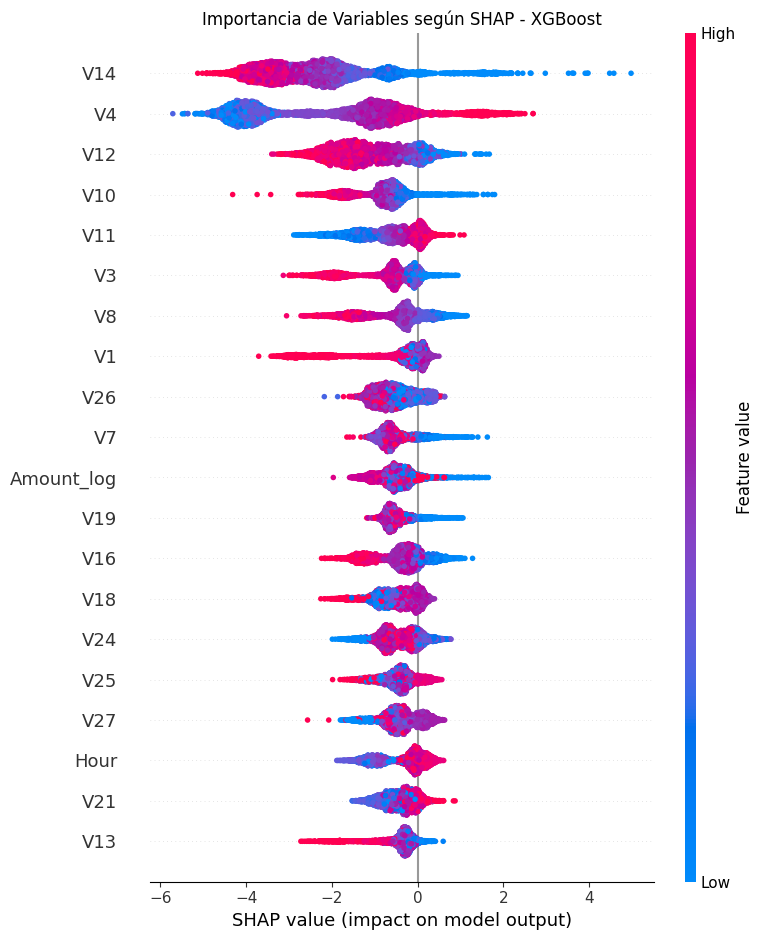

In [31]:
# Creamos el objeto explainer sobre el modelo XGBoost
explainer = shap.TreeExplainer(mejor_modelo)

# Calculamos valores SHAP en una muestra (para acelerar el cálculo)
X_sample = X_test[:5000]  # usamos 5000 instancias como ejemplo
shap_values = explainer.shap_values(X_sample)

# Summary plot: importancia global de las variables
plt.title("Importancia de Variables según SHAP - XGBoost")
shap.summary_plot(shap_values, X_sample, feature_names=X.columns)

**SHAP (XGBoost):**

El gráfico muestra que ciertas variables anonimizadas tienen un impacto mucho mayor en la predicción de fraude que otras.  
Entre ellas destacan **V14, V4, V12, V10 y V11**, que aparecen como las más influyentes. Esto coincide con lo reportado en estudios previos sobre este dataset, donde algunos componentes principales concentran patrones clave asociados al fraude.  

Es importante notar que variables como **`Amount_log`** y **`Hour`** tienen menor peso relativo, lo que sugiere que el monto de la transacción o la hora del día, si bien aportan información, no son determinantes por sí mismos en la detección del fraude.  

En síntesis, el modelo no depende de una sola variable sino de un **conjunto diverso de factores combinados**, lo cual refuerza la robustez de sus predicciones.  
Aunque las variables `V1–V28` están anonimizadas y no tienen interpretación directa, este análisis confirma que el modelo captura patrones complejos en los datos y los utiliza de manera consistente para distinguir entre transacciones legítimas y fraudulentas.


### Posibles mejoras futuras
- Optimización de hiperparámetros mediante búsqueda en grid o bayesiana.  
- Evaluación de técnicas de *undersampling/oversampling* más sofisticadas para el desbalance.  
- Prueba de modelos de *deep learning* adaptados a detección de anomalías.  

## **Con este análisis concluimos nuestra entrega del Trabajo Final.  Muchas gracias por su tiempo y atención.**
